# Deep Learning Text Classification Model

In [225]:
# %conda install tensorflow
# %conda install conda-forge::tensorflow-datasets
# %conda install conda-forge::tf-keras=2.17

In [226]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import datasets
import transformers
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

# from tensorflow.keras import Input
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Dense, Bidirectional
# from tensorflow.keras.regularizers import L1, L2, L1L2
# from tensorflow.keras.optimizers import Adam, RMSprop

from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification

## Import Data

In [227]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
print(f"Train: {train.shape}\nTest: {test.shape}")

Train: (7613, 5)
Test: (3263, 4)


In [228]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [229]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [230]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


* The compulsory columns, `text` and `target`, have no missing values.

## Exploratory Data Analysis

### `keyword`

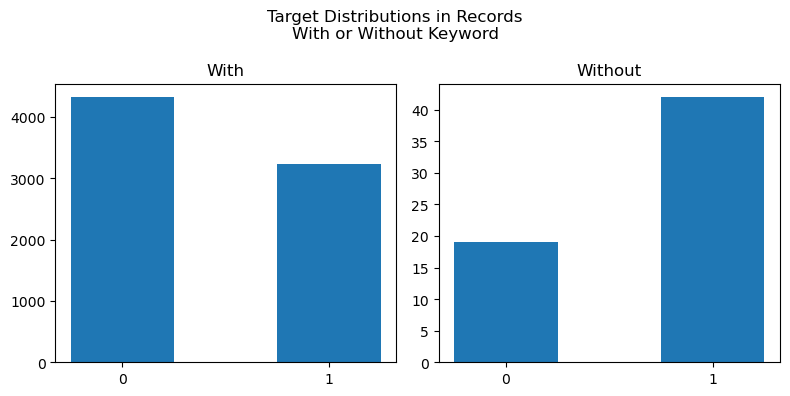

In [231]:
keyword_nomiss = train.loc[train['keyword'].notna(), ['keyword','target']]
keyword_miss = train.loc[train['keyword'].isna(), ['keyword','target']]

kw_nomiss_targets = keyword_nomiss['target'].value_counts()
kw_miss_targets = keyword_miss['target'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].bar(kw_nomiss_targets.index, kw_nomiss_targets, width=.5)
axes[0].set_xticks([0,1])
axes[0].set_title('With')
axes[1].bar(kw_miss_targets.index, kw_miss_targets, width=.5)
axes[1].set_xticks([0,1])
axes[1].set_title('Without')
fig.suptitle('Target Distributions in Records\nWith or Without Keyword')
fig.tight_layout()
plt.show()

* There is an apparent difference in `Target` distributions between records *`with`* and *`without`* `keyword`.
* Therefore, a new independent variable `with_keyword` should be considered.

### `location`

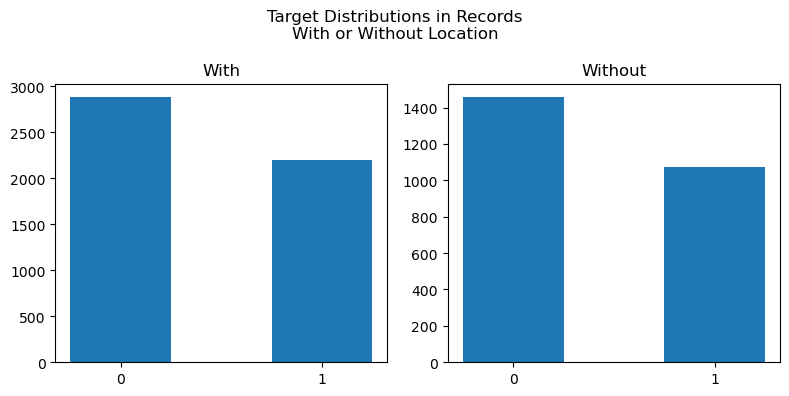

In [232]:
location_nomiss = train.loc[train['location'].notna(), ['location','target']]
location_miss = train.loc[train['location'].isna(), ['location','target']]

loc_nomiss_targets = location_nomiss['target'].value_counts()
loc_miss_targets = location_miss['target'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].bar(loc_nomiss_targets.index, loc_nomiss_targets, width=.5)
axes[0].set_xticks([0,1])
axes[0].set_title('With')
axes[1].bar(loc_miss_targets.index, loc_miss_targets, width=.5)
axes[1].set_xticks([0,1])
axes[1].set_title('Without')
fig.suptitle('Target Distributions in Records\nWith or Without Location')
fig.tight_layout()
plt.show()

* On the contrary, the `Target` distributions in the records *`with`* or *`without`* `location` show almost the same pattern.

## Create and Remove Columns

In [233]:
train['with_keyword'] = train['keyword'].notna().astype(int)
test['with_keyword'] = test['keyword'].notna().astype(int)
train['with_keyword'].value_counts()

with_keyword
1    7552
0      61
Name: count, dtype: int64

In [234]:
train.drop(columns='id', inplace=True)
test.drop(columns='id', inplace=True)
train.head()

,keyword,location,text,target,with_keyword
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,0
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0


## Text Preprocessing

In [235]:
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /Users/moswai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/moswai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/moswai/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/moswai/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Lowercase

In [236]:
train_lower = train['text'].str.lower()
test_lower = test['text'].str.lower()

### Punctuation

In [237]:
def punctuation(inputs):
    return re.sub(r'[^a-zA-Z]', ' ', inputs)
train_lower_punc = train_lower.apply(punctuation)
test_lower_punc = test_lower.apply(punctuation)

### Tokenisation

In [238]:
def tokenization(inputs):
    return word_tokenize(inputs)
train_tokens = train_lower_punc.apply(tokenization)
test_tokens = test_lower_punc.apply(tokenization)

### Stopword

In [239]:
stop_words = set(stopwords.words('english'))
# stop_words.remove('not')
stop_words.add('br')
def stopwords_remove(inputs):
    return [word for word in inputs if word not in stop_words]
train_tokens_stop = train_tokens.apply(stopwords_remove)
test_tokens_stop = test_tokens.apply(stopwords_remove)

### Lemmatisation

In [240]:
lemmatizer = WordNetLemmatizer()
def lemmatization(inputs):
    return [lemmatizer.lemmatize(word=word, pos='v') for word in inputs]
train_final = train_tokens_stop.apply(lemmatization)
test_final = test_tokens_stop.apply(lemmatization)

In [241]:
train['final'] = train_final
test['final'] = test_final
train.head()

,keyword,location,text,target,with_keyword,final
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0,"[deeds, reason, earthquake, may, allah, forgiv..."
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0,"[forest, fire, near, la, ronge, sask, canada]"
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0,"[residents, ask, shelter, place, notify, offic..."
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,0,"[people, receive, wildfires, evacuation, order..."
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0,"[get, send, photo, ruby, alaska, smoke, wildfi..."


## Visualisation

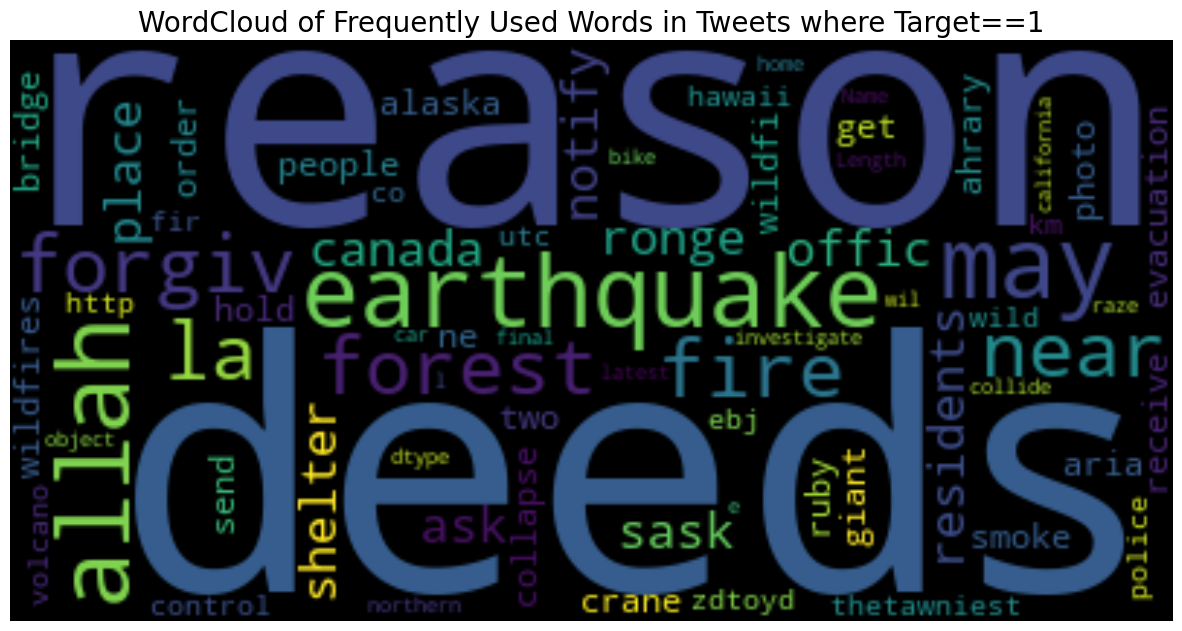

In [242]:
train_1 = train.loc[train['target']==1, 'final']

word_cloud_1 = WordCloud(max_words=500, stopwords=stop_words, random_state=4).generate(str((train_1)))
plt.figure(figsize=(15, 10))
plt.imshow(word_cloud_1, interpolation='bilinear')
plt.title('WordCloud of Frequently Used Words in Tweets where Target==1', fontsize=20)
plt.axis("off")
plt.show()

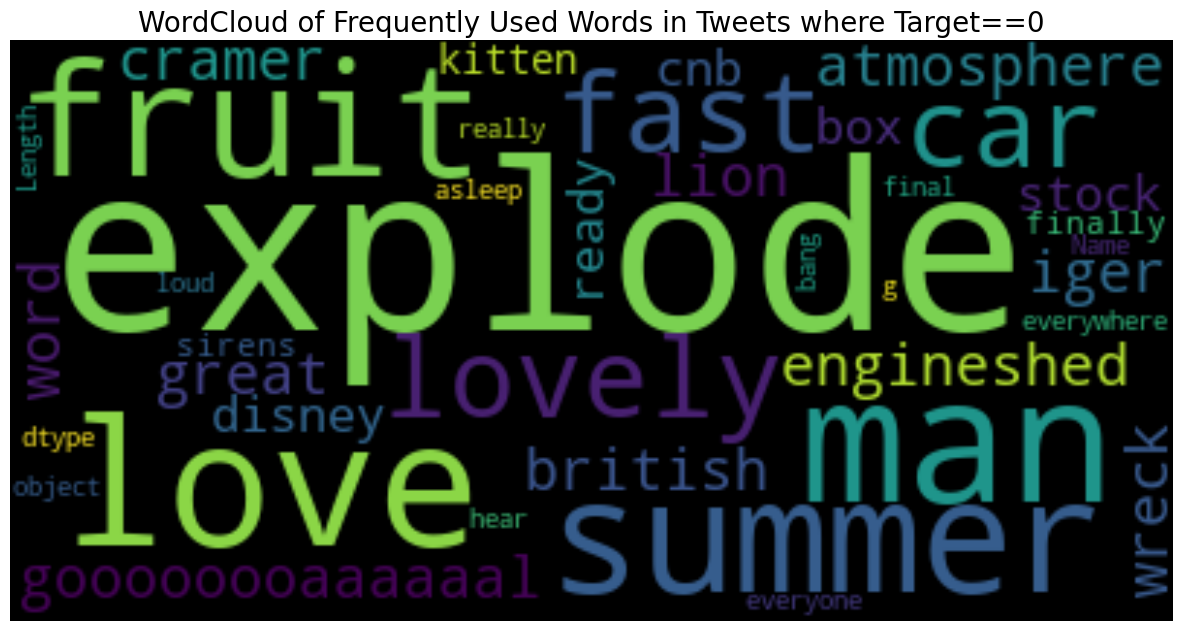

In [243]:
train_0 = train.loc[train['target']==0, 'final']

word_cloud_0 = WordCloud(max_words=500, stopwords=stop_words, random_state=4).generate(str((train_0)))
plt.figure(figsize=(15, 10))
plt.imshow(word_cloud_0, interpolation='bilinear')
plt.title('WordCloud of Frequently Used Words in Tweets where Target==0', fontsize=20)
plt.axis("off")
plt.show()

## Data Preprocessing

In [244]:
X_train, X_val, y_train, y_val = train_test_split(train.loc[:, ['text']], train.loc[:, 'target'], train_size=5000, random_state=4)
X_test = test.loc[:, ['text']]
print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}")
print(f"X_val: {X_val.shape}\ny_val: {y_val.shape}")
print(f"X_test: {X_test.shape}")

X_train: (5000, 1)
y_train: (5000,)
X_val: (2613, 1)
y_val: (2613,)
X_test: (3263, 1)


## Modelling

### Simple Univariate Neural Network Model

In [245]:
max_tokens = 20000
output_sequence_length = 256
output_dim = 128

vectorizer_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens, 
    output_mode='int', 
    standardize='lower_and_strip_punctuation', 
    ngrams=1, 
    output_sequence_length=output_sequence_length)
vectorizer_layer.adapt(X_train)

embedding_layer = tf.keras.layers.Embedding(
    input_dim=max_tokens, 
    output_dim=output_dim, 
    input_length=output_sequence_length)

/opt/anaconda3/envs/venv_hugging/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [246]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(X_train.shape[1],), dtype=tf.string))
model.add(vectorizer_layer)
model.add(embedding_layer)
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5)
model.evaluate(X_val, y_val)

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5511 - loss: 0.6905
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5802 - loss: 0.6830
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5868 - loss: 0.6787
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5682 - loss: 0.6854
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5748 - loss: 0.6809
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - accuracy: 0.5811 - loss: 0.6782


[0.6784688234329224, 0.5803135633468628]

### Multi-Layer Model

In [260]:
model_ml = tf.keras.models.Sequential()
model_ml.add(tf.keras.Input(shape=(X_train.shape[1],), dtype=tf.string))
model_ml.add(vectorizer_layer)
model_ml.add(embedding_layer)
model_ml.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='elu')))
model_ml.add(tf.keras.layers.Dense(16, activation='elu'))
model_ml.add(tf.keras.layers.Dense(8, activation='elu'))
model_ml.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model_ml.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.0001), loss='binary_crossentropy', metrics=['accuracy'])
model_ml.fit(X_train, y_train, batch_size=32, epochs=5)
model_ml.evaluate(X_val, y_val)

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.8268 - loss: 0.6010
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - accuracy: 0.9213 - loss: 0.3408
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.9345 - loss: 0.2345
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - accuracy: 0.9424 - loss: 0.1883
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - accuracy: 0.9455 - loss: 0.1664
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7669 - loss: 0.5451


[0.5303410291671753, 0.765021026134491]